In [8]:
import numpy as np

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

# 데이터 로딩

In [2]:
trainset_raw = torchvision.datasets.MNIST(root='./data', train=True, download=True)
testset_raw = torchvision.datasets.MNIST(root='./data', train=False, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 507kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.67MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.91MB/s]


In [26]:
for row in trainset_raw.data[0].numpy():
    print(" ".join(f"{v:3}" for v in row))

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0
  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0
  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0
  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241   0   0   0   0   0   0   0   0 

In [27]:
# numpy → tensor 변환 & 정규화
def preprocess_mnist(dataset):
    images = dataset.data.float() / 255.0  # [0,255] → [0,1]
    mean, std = images.mean() , images.std()
    # images = (images - mean) / std         # Normalize
    labels = dataset.targets
    return images, labels

In [28]:
train_images, train_labels = preprocess_mnist(trainset_raw)
test_images, test_labels = preprocess_mnist(testset_raw)

In [29]:
# train/val split
train_size = int(0.8 * len(train_images))
val_size = len(train_images) - train_size

In [30]:
train_images, val_images = torch.utils.data.random_split(train_images, [train_size, val_size])
train_labels, val_labels = torch.utils.data.random_split(train_labels, [train_size, val_size])

In [31]:
trainloader = torch.utils.data.DataLoader(list(zip(train_images, train_labels)), batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(list(zip(val_images, val_labels)), batch_size=64, shuffle=False)

# 모델 생성

In [32]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습

In [34]:
train_losses, val_losses, val_accuracies = [], [], []

In [35]:
for epoch in range(5):
    model.train()
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(trainloader))

    # ----- Validation -----
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/5], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

Epoch [1/5], Train Loss: 2.3027, Val Loss: 2.3016, Val Acc: 11.09%
Epoch [2/5], Train Loss: 2.3019, Val Loss: 2.3020, Val Acc: 11.19%
Epoch [3/5], Train Loss: 2.3009, Val Loss: 2.3024, Val Acc: 11.32%
Epoch [4/5], Train Loss: 2.3000, Val Loss: 2.3043, Val Acc: 11.16%
Epoch [5/5], Train Loss: 2.2978, Val Loss: 2.3069, Val Acc: 10.53%


# 학습결과 확인

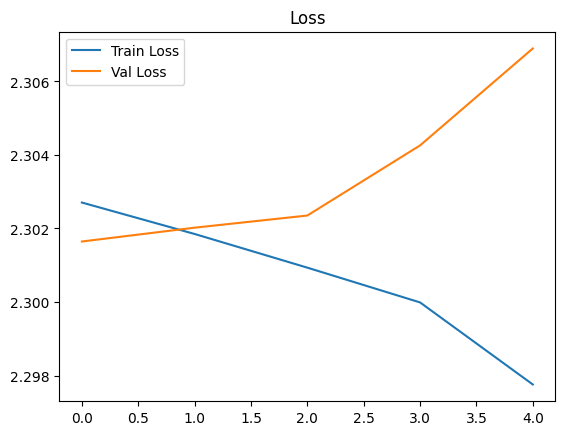

In [36]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

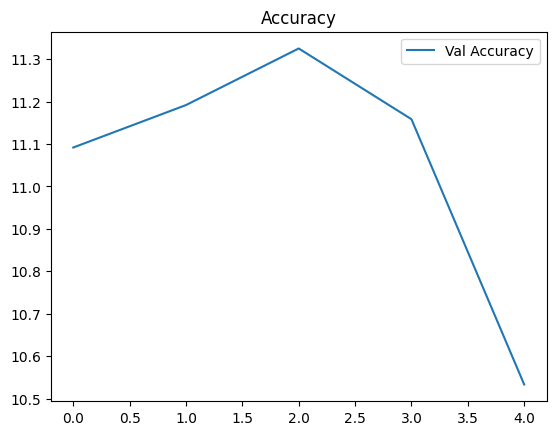

In [37]:
plt.figure()
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()